In [3]:
# libs
import warnings

import matplotlib.pyplot as plt
import matplotlib.image as img
from IPython.display import clear_output
from matplotlib import cm

import random
import pandas as pd
import numpy as np

import torch
import torch.nn.functional as F
import torchvision
from torch import nn
from torchvision import transforms
from sklearn.model_selection import train_test_split


import time
from tqdm import tqdm
from tqdm.notebook import trange

from PIL import Image
from skimage.transform import resize
from skimage import transform

warnings.filterwarnings("ignore")
%matplotlib inline

In [4]:
# func

def im_loader_to_matrix(df: pd.DataFrame):
    matricies_of_images = list()
    for i, s in zip(range(df.shape[0]+1), tqdm(range(df.shape[0]))):
        image = df['image'].iloc[i]
        image = requests.get(image).content
        image = plt.imread(io.BytesIO(image), format='JPG')
        matricies_of_images.append(image)

    df['image_matricies'] = matricies_of_images


def print_worktime(start):

    duration = time.time() - start
    duration = round(duration / 60, 3)

    print(f"Код отработал за: {duration} минут")


# losses to minimize

def compute_loss(prediction, reference):
    """
    Расчет MSE
    """
    return torch.mean((prediction - reference) ** 2)

def compute_mae(reference, prediction):
    """
    Расчет MAE
    """
    return torch.abs(torch.exp(reference - 1) - torch.exp(prediction - 1)).mean()


def normaliser(img: np.array):

  transform = transforms.Compose([
      transforms.ToTensor()
  ])
  img_tr = transform(img)
  mean, std = img_tr.mean([1,2]), img_tr.std([1,2])

  transform_norm = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean, std)
  ])

  img_normalized = transform_norm(img)

  return img_normalized

def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Подготовка трейн датасета




In [5]:
labels = np.load('drive/MyDrive/hands_labels.npy', allow_pickle=True)
images = np.load('drive/MyDrive/hands_images.npy', allow_pickle=True)

im_list = [resize(torch.as_tensor(im, dtype=torch.float32), (224, 224)) for im in images]
label_list = [torch.as_tensor(l-1, dtype=torch.float32) for l in labels]

In [6]:
len(label_list)

815

In [7]:
type(im_list)

list

In [8]:
type(label_list[0])

torch.Tensor

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(im_list, label_list, test_size=0.2, random_state=42)

print("Train size = ", len(X_train))
print("Validation size = ", len(X_test))

Train size =  652
Validation size =  163


In [10]:
# удаляем фото, несоответствующие размерности
X_test = [photo for photo in X_test if photo.shape == (224, 224, 3)]
X_train = [photo for photo in X_train if photo.shape == (224, 224, 3)]

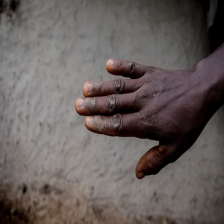

In [11]:
result = Image.fromarray(np.array(X_train[0]).astype(np.uint8))
result.convert('RGB')

# Собственная модель

### Нормализация пикселей изображения

Text(0.5, 1.0, 'Распределение пикселей')

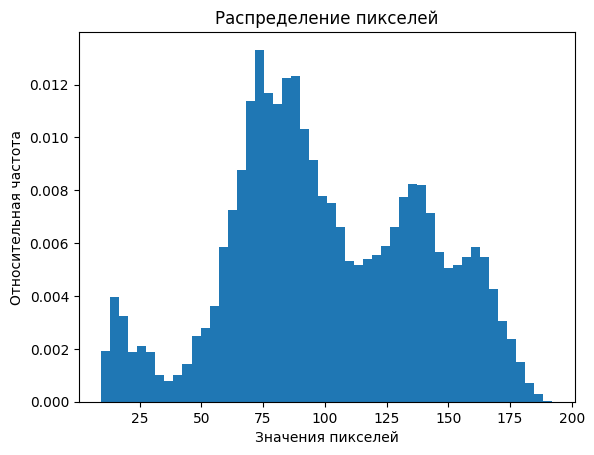

In [12]:
img_np = np.array(X_train[100])

# plot the pixel values
plt.hist(img_np.ravel(), bins=50, density=True)
plt.xlabel("Значения пикселей")
plt.ylabel("Относительная частота")
plt.title("Распределение пикселей")

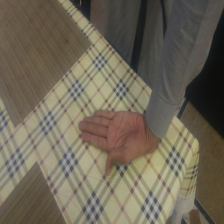

In [13]:
result = Image.fromarray(np.array(X_train[100]).astype(np.uint8))
result.convert('RGB')

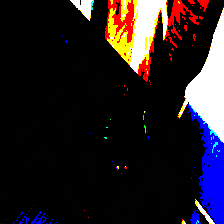

In [14]:
img_normalized = normaliser(X_train[100])
img_normalized = np.array(img_normalized)
img_normalized_tr = img_normalized.transpose(1, 2, 0)
result = Image.fromarray(np.array(img_normalized_tr).astype(np.uint8))
result.convert('RGB')

Text(0.5, 1.0, 'Распределение пикселей')

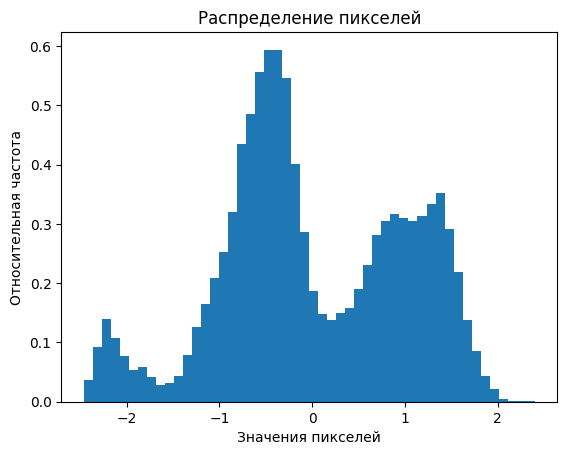

In [15]:
# img_np = np.array(X_train[0])

# plot the pixel values
plt.hist(img_normalized.ravel(), bins=50, density=True)
plt.xlabel("Значения пикселей")
plt.ylabel("Относительная частота")
plt.title("Распределение пикселей")

# Обучение CNN

In [16]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [96]:
model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=10, kernel_size=5),
    nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3),
    nn.BatchNorm2d(20),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(3380, 3000),
    nn.ReLU(),
    nn.Linear(3000, 2500),
    nn.ReLU(),
    nn.Linear(2500, 2000),
    nn.Tanh(),
    nn.Linear(2000, 1500),
    nn.ReLU(),
    nn.Linear(1500, 1000),
    nn.Tanh(),
    nn.Linear(1000, 500),
    nn.ReLU(),
    nn.Linear(500, 100),
    nn.Linear(100, 5),
    nn.Dropout(0.3)
)

opt = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.005)
# opt = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(opt, gamma=0.1, step_size=20)

In [97]:
train_transforms = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.ColorJitter(),
                                transforms.RandomCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.Resize((32,32)),
                                transforms.Normalize(mean=(0.5,), std=(0.5,))])

test_transforms = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Resize((32,32)),
                                transforms.Normalize(mean=(0.5,), std=(0.5,))])

In [98]:
dataset = [[i,j] for i, j in zip(im_list, label_list) if i.shape == (224, 224, 3)]

train_set, val_set = torch.utils.data.random_split(
    dataset,
    [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))]
)

train_set = [[torch.transpose(train_transforms(pic[0]), 2,1), pic[1]] for pic in train_set]
val_set = [[torch.transpose(test_transforms(pic[0]), 2,1), pic[1]] for pic in val_set]

train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=40, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=40, shuffle=True)

In [99]:
num_epochs = 100
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

# loss_func = nn.HuberLoss(delta=1.0)
# loss_func = compute_loss
loss_func = nn.CrossEntropyLoss()

for epoch in range(num_epochs):

    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    total_acc_train = 0
    total_loss_train = 0
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for x_train, y_train in tqdm(train_dataloader):
        # train on batch
        # x_train = train_transforms(np.array(x_train))
        # x_train = normaliser(x_train)

        # x_train = torch.reshape(x_train,(1,3, 32, 32))
        outputs = model(x_train)
        # print(outputs)
        # loss = compute_loss(y_train, outputs)
        outputs = torch.squeeze(outputs, 0)
        loss = F.cross_entropy(outputs, y_train.long())
        loss.backward()
        opt.step()
        opt.zero_grad()
        # _, preds = torch.max(outputs, 0) # taking the highest value of prediction.
        running_loss += loss.item()
        acc = (outputs.argmax(dim=1) == y_train).sum().item()
        total_acc_train += acc
        # running_corrects += torch.sum(preds == y_train.data)
    # And a full pass over the validation data:
    total_acc_val = 0
    total_loss_val = 0
    model.train(False) # disable dropout / use averages for batch_norm
    with torch.no_grad():
      for x_val, y_val in tqdm(val_dataloader):
          # x_val = test_transforms(x_val)
          # x_val = torch.reshape(x_val,(50,3, 32, 32))
          # y_val = y_val
          y_out = model(x_val)
          y_out = torch.squeeze(y_out, 0)
          val_loss = F.cross_entropy(y_out, y_val.long())
          # val_loss = compute_loss(y_val, y_out)
          _, y_pred = torch.max(y_out, 0)
          val_running_loss += val_loss.item()
          # val_running_corrects += torch.sum(y_pred == y_val.data)
          acc = (y_out.argmax(dim=1) == y_val).sum().item()
          total_acc_val += acc
    scheduler.step()

    epoch_loss = running_loss/len(X_train) # loss per epoch
    # epoch_acc = running_corrects.float()/ len(X_train) # accuracy per epoch
    running_loss_history.append(epoch_loss) # appending for displaying
    running_corrects_history.append(total_acc_train / len(train_set))

    val_epoch_loss = val_running_loss/len(X_test)
    # val_epoch_acc = val_running_corrects.float()/len(X_test)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(total_acc_val / len(val_set))
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print('epoch :', (epoch+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, total_acc_train / len(train_set)))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, total_acc_val / len(val_set)))

100%|██████████| 5/5 [00:00<00:00, 20.80it/s]


Epoch 1 of 100 took 4.727s
epoch : 1
training loss: 0.0421, acc 0.1856 
validation loss: 0.0492, validation acc 0.1656 


100%|██████████| 5/5 [00:00<00:00, 18.86it/s]


Epoch 2 of 100 took 4.732s
epoch : 2
training loss: 0.0420, acc 0.2071 
validation loss: 0.0494, validation acc 0.2025 


100%|██████████| 5/5 [00:00<00:00, 24.06it/s]


Epoch 3 of 100 took 4.874s
epoch : 3
training loss: 0.0417, acc 0.2301 
validation loss: 0.0492, validation acc 0.1656 


100%|██████████| 5/5 [00:00<00:00, 19.93it/s]


Epoch 4 of 100 took 4.357s
epoch : 4
training loss: 0.0423, acc 0.2285 
validation loss: 0.0509, validation acc 0.2331 


100%|██████████| 5/5 [00:00<00:00, 19.51it/s]


Epoch 5 of 100 took 4.459s
epoch : 5
training loss: 0.0410, acc 0.2761 
validation loss: 0.0464, validation acc 0.2209 


100%|██████████| 5/5 [00:00<00:00, 23.84it/s]


Epoch 6 of 100 took 4.639s
epoch : 6
training loss: 0.0415, acc 0.2469 
validation loss: 0.0492, validation acc 0.2147 


100%|██████████| 5/5 [00:00<00:00, 23.87it/s]


Epoch 7 of 100 took 4.827s
epoch : 7
training loss: 0.0415, acc 0.2316 
validation loss: 0.0498, validation acc 0.2515 


100%|██████████| 5/5 [00:00<00:00, 16.40it/s]


Epoch 8 of 100 took 4.876s
epoch : 8
training loss: 0.0413, acc 0.2669 
validation loss: 0.0476, validation acc 0.2393 


100%|██████████| 5/5 [00:00<00:00, 20.91it/s]


Epoch 9 of 100 took 4.286s
epoch : 9
training loss: 0.0401, acc 0.2991 
validation loss: 0.0495, validation acc 0.2945 


100%|██████████| 5/5 [00:00<00:00, 24.20it/s]


Epoch 10 of 100 took 4.337s
epoch : 10
training loss: 0.0401, acc 0.2669 
validation loss: 0.0485, validation acc 0.2761 


100%|██████████| 5/5 [00:00<00:00, 20.57it/s]


Epoch 11 of 100 took 4.895s
epoch : 11
training loss: 0.0402, acc 0.2791 
validation loss: 0.0495, validation acc 0.2331 


100%|██████████| 5/5 [00:00<00:00, 23.18it/s]


Epoch 12 of 100 took 4.357s
epoch : 12
training loss: 0.0407, acc 0.2669 
validation loss: 0.0473, validation acc 0.2761 


100%|██████████| 5/5 [00:00<00:00, 19.80it/s]


Epoch 13 of 100 took 4.495s
epoch : 13
training loss: 0.0397, acc 0.2960 
validation loss: 0.0476, validation acc 0.3129 


100%|██████████| 5/5 [00:00<00:00, 22.07it/s]


Epoch 14 of 100 took 4.994s
epoch : 14
training loss: 0.0394, acc 0.2853 
validation loss: 0.0474, validation acc 0.2454 


100%|██████████| 5/5 [00:00<00:00, 19.54it/s]


Epoch 15 of 100 took 4.350s
epoch : 15
training loss: 0.0396, acc 0.3021 
validation loss: 0.0465, validation acc 0.3067 


100%|██████████| 5/5 [00:00<00:00, 19.13it/s]


Epoch 16 of 100 took 4.206s
epoch : 16
training loss: 0.0395, acc 0.3083 
validation loss: 0.0633, validation acc 0.2025 


100%|██████████| 5/5 [00:00<00:00, 23.62it/s]


Epoch 17 of 100 took 4.650s
epoch : 17
training loss: 0.0423, acc 0.2239 
validation loss: 0.0493, validation acc 0.2025 


100%|██████████| 5/5 [00:00<00:00, 23.70it/s]


Epoch 18 of 100 took 4.295s
epoch : 18
training loss: 0.0414, acc 0.2408 
validation loss: 0.0482, validation acc 0.2270 


100%|██████████| 5/5 [00:00<00:00,  9.24it/s]


Epoch 19 of 100 took 6.214s
epoch : 19
training loss: 0.0399, acc 0.2699 
validation loss: 0.0469, validation acc 0.3313 


100%|██████████| 5/5 [00:00<00:00, 19.86it/s]


Epoch 20 of 100 took 4.515s
epoch : 20
training loss: 0.0398, acc 0.3021 
validation loss: 0.0495, validation acc 0.2209 


100%|██████████| 5/5 [00:00<00:00, 21.03it/s]


Epoch 21 of 100 took 4.376s
epoch : 21
training loss: 0.0385, acc 0.3098 
validation loss: 0.0483, validation acc 0.3006 


100%|██████████| 5/5 [00:00<00:00, 23.93it/s]


Epoch 22 of 100 took 4.982s
epoch : 22
training loss: 0.0375, acc 0.3328 
validation loss: 0.0467, validation acc 0.3067 


100%|██████████| 5/5 [00:00<00:00, 23.72it/s]


Epoch 23 of 100 took 4.709s
epoch : 23
training loss: 0.0378, acc 0.3282 
validation loss: 0.0453, validation acc 0.3313 


100%|██████████| 5/5 [00:00<00:00, 16.60it/s]


Epoch 24 of 100 took 4.601s
epoch : 24
training loss: 0.0377, acc 0.3344 
validation loss: 0.0443, validation acc 0.3620 


100%|██████████| 5/5 [00:00<00:00, 21.75it/s]


Epoch 25 of 100 took 4.915s
epoch : 25
training loss: 0.0378, acc 0.3267 
validation loss: 0.0455, validation acc 0.3190 


100%|██████████| 5/5 [00:00<00:00, 21.32it/s]


Epoch 26 of 100 took 4.460s
epoch : 26
training loss: 0.0375, acc 0.3175 
validation loss: 0.0458, validation acc 0.3067 


100%|██████████| 5/5 [00:00<00:00, 19.08it/s]


Epoch 27 of 100 took 4.788s
epoch : 27
training loss: 0.0368, acc 0.3420 
validation loss: 0.0467, validation acc 0.3374 


100%|██████████| 5/5 [00:00<00:00, 22.39it/s]


Epoch 28 of 100 took 4.877s
epoch : 28
training loss: 0.0371, acc 0.3497 
validation loss: 0.0523, validation acc 0.2699 


100%|██████████| 5/5 [00:00<00:00, 21.25it/s]


Epoch 29 of 100 took 4.446s
epoch : 29
training loss: 0.0365, acc 0.3466 
validation loss: 0.0456, validation acc 0.3252 


100%|██████████| 5/5 [00:00<00:00, 17.04it/s]


Epoch 30 of 100 took 5.170s
epoch : 30
training loss: 0.0364, acc 0.3804 
validation loss: 0.0442, validation acc 0.3006 


100%|██████████| 5/5 [00:00<00:00, 21.86it/s]


Epoch 31 of 100 took 5.291s
epoch : 31
training loss: 0.0360, acc 0.3451 
validation loss: 0.0456, validation acc 0.3804 


100%|██████████| 5/5 [00:00<00:00, 17.93it/s]


Epoch 32 of 100 took 4.789s
epoch : 32
training loss: 0.0358, acc 0.3681 
validation loss: 0.0485, validation acc 0.3620 


100%|██████████| 5/5 [00:00<00:00, 22.91it/s]


Epoch 33 of 100 took 5.075s
epoch : 33
training loss: 0.0359, acc 0.3742 
validation loss: 0.0484, validation acc 0.2454 


100%|██████████| 5/5 [00:00<00:00, 24.37it/s]


Epoch 34 of 100 took 4.733s
epoch : 34
training loss: 0.0352, acc 0.3834 
validation loss: 0.0444, validation acc 0.2699 


100%|██████████| 5/5 [00:00<00:00, 19.31it/s]


Epoch 35 of 100 took 5.444s
epoch : 35
training loss: 0.0354, acc 0.3681 
validation loss: 0.0463, validation acc 0.3067 


100%|██████████| 5/5 [00:00<00:00, 23.40it/s]


Epoch 36 of 100 took 4.707s
epoch : 36
training loss: 0.0342, acc 0.4126 
validation loss: 0.0488, validation acc 0.3374 


100%|██████████| 5/5 [00:00<00:00, 23.50it/s]


Epoch 37 of 100 took 4.610s
epoch : 37
training loss: 0.0345, acc 0.4141 
validation loss: 0.0482, validation acc 0.3190 


100%|██████████| 5/5 [00:00<00:00, 21.06it/s]


Epoch 38 of 100 took 4.879s
epoch : 38
training loss: 0.0344, acc 0.4248 
validation loss: 0.0543, validation acc 0.2577 


100%|██████████| 5/5 [00:00<00:00, 18.39it/s]


Epoch 39 of 100 took 4.679s
epoch : 39
training loss: 0.0349, acc 0.3834 
validation loss: 0.0495, validation acc 0.2883 


100%|██████████| 5/5 [00:00<00:00, 18.93it/s]


Epoch 40 of 100 took 4.999s
epoch : 40
training loss: 0.0333, acc 0.4294 
validation loss: 0.0441, validation acc 0.3067 


100%|██████████| 5/5 [00:00<00:00, 20.12it/s]


Epoch 41 of 100 took 4.858s
epoch : 41
training loss: 0.0324, acc 0.4340 
validation loss: 0.0454, validation acc 0.3558 


100%|██████████| 5/5 [00:00<00:00, 25.12it/s]


Epoch 42 of 100 took 4.560s
epoch : 42
training loss: 0.0323, acc 0.4248 
validation loss: 0.0477, validation acc 0.3436 


100%|██████████| 5/5 [00:00<00:00, 21.36it/s]


Epoch 43 of 100 took 5.306s
epoch : 43
training loss: 0.0316, acc 0.4555 
validation loss: 0.0445, validation acc 0.3129 


100%|██████████| 5/5 [00:00<00:00, 19.80it/s]


Epoch 44 of 100 took 4.609s
epoch : 44
training loss: 0.0312, acc 0.4893 
validation loss: 0.0445, validation acc 0.3252 


100%|██████████| 5/5 [00:00<00:00, 17.83it/s]


Epoch 45 of 100 took 4.750s
epoch : 45
training loss: 0.0317, acc 0.4509 
validation loss: 0.0435, validation acc 0.3558 


100%|██████████| 5/5 [00:00<00:00, 22.48it/s]


Epoch 46 of 100 took 5.358s
epoch : 46
training loss: 0.0311, acc 0.4877 
validation loss: 0.0473, validation acc 0.3681 


100%|██████████| 5/5 [00:00<00:00, 18.63it/s]


Epoch 47 of 100 took 4.811s
epoch : 47
training loss: 0.0312, acc 0.4540 
validation loss: 0.0440, validation acc 0.3252 


100%|██████████| 5/5 [00:00<00:00, 18.85it/s]


Epoch 48 of 100 took 4.958s
epoch : 48
training loss: 0.0308, acc 0.5169 
validation loss: 0.0448, validation acc 0.3374 


100%|██████████| 5/5 [00:00<00:00, 21.82it/s]


Epoch 49 of 100 took 4.562s
epoch : 49
training loss: 0.0312, acc 0.4954 
validation loss: 0.0494, validation acc 0.3865 


100%|██████████| 5/5 [00:00<00:00, 22.06it/s]


Epoch 50 of 100 took 4.417s
epoch : 50
training loss: 0.0303, acc 0.5184 
validation loss: 0.0468, validation acc 0.3313 


100%|██████████| 5/5 [00:00<00:00, 23.70it/s]


Epoch 51 of 100 took 5.081s
epoch : 51
training loss: 0.0304, acc 0.5399 
validation loss: 0.0471, validation acc 0.3988 


100%|██████████| 5/5 [00:00<00:00, 15.58it/s]


Epoch 52 of 100 took 5.841s
epoch : 52
training loss: 0.0304, acc 0.4939 
validation loss: 0.0437, validation acc 0.3252 


100%|██████████| 5/5 [00:00<00:00, 20.71it/s]


Epoch 53 of 100 took 5.049s
epoch : 53
training loss: 0.0311, acc 0.5031 
validation loss: 0.0459, validation acc 0.3988 


100%|██████████| 5/5 [00:00<00:00, 23.32it/s]


Epoch 54 of 100 took 4.331s
epoch : 54
training loss: 0.0310, acc 0.5000 
validation loss: 0.0436, validation acc 0.3558 


100%|██████████| 5/5 [00:00<00:00, 20.34it/s]


Epoch 55 of 100 took 4.151s
epoch : 55
training loss: 0.0310, acc 0.4663 
validation loss: 0.0465, validation acc 0.3374 


100%|██████████| 5/5 [00:00<00:00, 16.06it/s]


Epoch 56 of 100 took 4.816s
epoch : 56
training loss: 0.0308, acc 0.5337 
validation loss: 0.0521, validation acc 0.3374 


100%|██████████| 5/5 [00:00<00:00, 23.13it/s]


Epoch 57 of 100 took 4.236s
epoch : 57
training loss: 0.0309, acc 0.4755 
validation loss: 0.0480, validation acc 0.3313 


100%|██████████| 5/5 [00:00<00:00, 23.37it/s]


Epoch 58 of 100 took 4.141s
epoch : 58
training loss: 0.0300, acc 0.5399 
validation loss: 0.0452, validation acc 0.3742 


100%|██████████| 5/5 [00:00<00:00,  7.91it/s]


Epoch 59 of 100 took 6.334s
epoch : 59
training loss: 0.0299, acc 0.5092 
validation loss: 0.0450, validation acc 0.3681 


100%|██████████| 5/5 [00:00<00:00, 21.71it/s]


Epoch 60 of 100 took 4.570s
epoch : 60
training loss: 0.0292, acc 0.5322 
validation loss: 0.0453, validation acc 0.3742 


100%|██████████| 5/5 [00:00<00:00, 18.42it/s]


Epoch 61 of 100 took 4.485s
epoch : 61
training loss: 0.0290, acc 0.5491 
validation loss: 0.0454, validation acc 0.3865 


100%|██████████| 5/5 [00:00<00:00, 22.36it/s]


Epoch 62 of 100 took 4.857s
epoch : 62
training loss: 0.0304, acc 0.5414 
validation loss: 0.0468, validation acc 0.3681 


100%|██████████| 5/5 [00:00<00:00, 22.69it/s]


Epoch 63 of 100 took 4.946s
epoch : 63
training loss: 0.0296, acc 0.5245 
validation loss: 0.0562, validation acc 0.3681 


100%|██████████| 5/5 [00:00<00:00,  9.21it/s]


Epoch 64 of 100 took 6.220s
epoch : 64
training loss: 0.0302, acc 0.5230 
validation loss: 0.0468, validation acc 0.3865 


100%|██████████| 5/5 [00:00<00:00, 24.20it/s]


Epoch 65 of 100 took 5.071s
epoch : 65
training loss: 0.0301, acc 0.5322 
validation loss: 0.0491, validation acc 0.3681 


100%|██████████| 5/5 [00:00<00:00, 21.20it/s]


Epoch 66 of 100 took 4.427s
epoch : 66
training loss: 0.0297, acc 0.5537 
validation loss: 0.0449, validation acc 0.3681 


100%|██████████| 5/5 [00:00<00:00, 23.28it/s]


Epoch 67 of 100 took 4.866s
epoch : 67
training loss: 0.0301, acc 0.5092 
validation loss: 0.0474, validation acc 0.3742 


100%|██████████| 5/5 [00:00<00:00, 21.87it/s]


Epoch 68 of 100 took 4.227s
epoch : 68
training loss: 0.0302, acc 0.5368 
validation loss: 0.0456, validation acc 0.3804 


100%|██████████| 5/5 [00:00<00:00, 18.24it/s]


Epoch 69 of 100 took 5.148s
epoch : 69
training loss: 0.0291, acc 0.5798 
validation loss: 0.0478, validation acc 0.3742 


100%|██████████| 5/5 [00:00<00:00, 22.92it/s]


Epoch 70 of 100 took 4.650s
epoch : 70
training loss: 0.0301, acc 0.5399 
validation loss: 0.0516, validation acc 0.3742 


100%|██████████| 5/5 [00:00<00:00, 12.75it/s]


Epoch 71 of 100 took 5.341s
epoch : 71
training loss: 0.0296, acc 0.5322 
validation loss: 0.0481, validation acc 0.3804 


100%|██████████| 5/5 [00:00<00:00,  7.38it/s]


Epoch 72 of 100 took 8.960s
epoch : 72
training loss: 0.0303, acc 0.5261 
validation loss: 0.0452, validation acc 0.3865 


100%|██████████| 5/5 [00:00<00:00, 24.26it/s]


Epoch 73 of 100 took 4.341s
epoch : 73
training loss: 0.0301, acc 0.5383 
validation loss: 0.0438, validation acc 0.3865 


100%|██████████| 5/5 [00:00<00:00, 21.68it/s]


Epoch 74 of 100 took 4.974s
epoch : 74
training loss: 0.0296, acc 0.5261 
validation loss: 0.0441, validation acc 0.3865 


100%|██████████| 5/5 [00:00<00:00, 24.07it/s]


Epoch 75 of 100 took 4.324s
epoch : 75
training loss: 0.0288, acc 0.5598 
validation loss: 0.0458, validation acc 0.3865 


100%|██████████| 5/5 [00:00<00:00, 18.44it/s]


Epoch 76 of 100 took 4.631s
epoch : 76
training loss: 0.0292, acc 0.5475 
validation loss: 0.0453, validation acc 0.3804 


100%|██████████| 5/5 [00:00<00:00, 24.08it/s]


Epoch 77 of 100 took 5.698s
epoch : 77
training loss: 0.0293, acc 0.5675 
validation loss: 0.0466, validation acc 0.3804 


100%|██████████| 5/5 [00:00<00:00, 23.57it/s]


Epoch 78 of 100 took 4.326s
epoch : 78
training loss: 0.0295, acc 0.5230 
validation loss: 0.0446, validation acc 0.3865 


100%|██████████| 5/5 [00:00<00:00, 17.87it/s]


Epoch 79 of 100 took 6.770s
epoch : 79
training loss: 0.0303, acc 0.5291 
validation loss: 0.0490, validation acc 0.3742 


100%|██████████| 5/5 [00:00<00:00, 23.99it/s]


Epoch 80 of 100 took 4.600s
epoch : 80
training loss: 0.0300, acc 0.5613 
validation loss: 0.0445, validation acc 0.3681 


100%|██████████| 5/5 [00:00<00:00, 23.34it/s]


Epoch 81 of 100 took 4.221s
epoch : 81
training loss: 0.0297, acc 0.5460 
validation loss: 0.0442, validation acc 0.3681 


100%|██████████| 5/5 [00:00<00:00, 22.46it/s]


Epoch 82 of 100 took 4.841s
epoch : 82
training loss: 0.0299, acc 0.5399 
validation loss: 0.0427, validation acc 0.3681 


100%|██████████| 5/5 [00:00<00:00, 24.54it/s]


Epoch 83 of 100 took 4.491s
epoch : 83
training loss: 0.0299, acc 0.5445 
validation loss: 0.0457, validation acc 0.3681 


100%|██████████| 5/5 [00:00<00:00, 22.54it/s]


Epoch 84 of 100 took 4.494s
epoch : 84
training loss: 0.0296, acc 0.5445 
validation loss: 0.0515, validation acc 0.3804 


100%|██████████| 5/5 [00:00<00:00, 21.70it/s]


Epoch 85 of 100 took 5.207s
epoch : 85
training loss: 0.0293, acc 0.5721 
validation loss: 0.0487, validation acc 0.3681 


100%|██████████| 5/5 [00:00<00:00, 22.95it/s]


Epoch 86 of 100 took 4.218s
epoch : 86
training loss: 0.0295, acc 0.5337 
validation loss: 0.0508, validation acc 0.3804 


100%|██████████| 5/5 [00:00<00:00, 18.47it/s]


Epoch 87 of 100 took 4.369s
epoch : 87
training loss: 0.0301, acc 0.5613 
validation loss: 0.0505, validation acc 0.3681 


100%|██████████| 5/5 [00:00<00:00, 24.17it/s]


Epoch 88 of 100 took 4.764s
epoch : 88
training loss: 0.0288, acc 0.5813 
validation loss: 0.0454, validation acc 0.3681 


100%|██████████| 5/5 [00:00<00:00, 20.58it/s]


Epoch 89 of 100 took 4.376s
epoch : 89
training loss: 0.0299, acc 0.5429 
validation loss: 0.0475, validation acc 0.3681 


100%|██████████| 5/5 [00:00<00:00, 19.20it/s]


Epoch 90 of 100 took 4.466s
epoch : 90
training loss: 0.0302, acc 0.5460 
validation loss: 0.0490, validation acc 0.3804 


100%|██████████| 5/5 [00:00<00:00, 24.96it/s]


Epoch 91 of 100 took 4.590s
epoch : 91
training loss: 0.0301, acc 0.5383 
validation loss: 0.0444, validation acc 0.3865 


100%|██████████| 5/5 [00:00<00:00, 18.99it/s]


Epoch 92 of 100 took 4.319s
epoch : 92
training loss: 0.0295, acc 0.5583 
validation loss: 0.0427, validation acc 0.3681 


100%|██████████| 5/5 [00:00<00:00, 15.50it/s]


Epoch 93 of 100 took 5.090s
epoch : 93
training loss: 0.0293, acc 0.5399 
validation loss: 0.0476, validation acc 0.3742 


100%|██████████| 5/5 [00:00<00:00, 24.21it/s]


Epoch 94 of 100 took 4.086s
epoch : 94
training loss: 0.0296, acc 0.5583 
validation loss: 0.0434, validation acc 0.3804 


100%|██████████| 5/5 [00:00<00:00, 21.51it/s]


Epoch 95 of 100 took 4.868s
epoch : 95
training loss: 0.0296, acc 0.5567 
validation loss: 0.0464, validation acc 0.3742 


100%|██████████| 5/5 [00:00<00:00, 22.99it/s]


Epoch 96 of 100 took 4.927s
epoch : 96
training loss: 0.0298, acc 0.5307 
validation loss: 0.0442, validation acc 0.3681 


100%|██████████| 5/5 [00:00<00:00, 20.91it/s]


Epoch 97 of 100 took 4.379s
epoch : 97
training loss: 0.0287, acc 0.5736 
validation loss: 0.0468, validation acc 0.3681 


100%|██████████| 5/5 [00:00<00:00, 23.10it/s]


Epoch 98 of 100 took 4.404s
epoch : 98
training loss: 0.0297, acc 0.5337 
validation loss: 0.0485, validation acc 0.3681 


100%|██████████| 5/5 [00:00<00:00, 22.52it/s]


Epoch 99 of 100 took 5.061s
epoch : 99
training loss: 0.0305, acc 0.5138 
validation loss: 0.0449, validation acc 0.3742 


100%|██████████| 5/5 [00:00<00:00, 18.40it/s]

Epoch 100 of 100 took 4.408s
epoch : 100
training loss: 0.0292, acc 0.5445 
validation loss: 0.0478, validation acc 0.3681 


In [100]:
x_demo = test_transforms(X_test[10])
x_demo = torch.reshape(x_demo,(1,3, 32, 32))
# y_val = y_val
y_out = model(x_demo)
y_out = torch.squeeze(y_out, 0)
# val_loss = loss_func(y_out, y_val.long())
# val_loss = compute_loss(y_val, y_out)
_, y_pred = torch.max(y_out, 0)

In [101]:
y_pred

tensor(4)

In [102]:
Y_test[10]

tensor(2.)

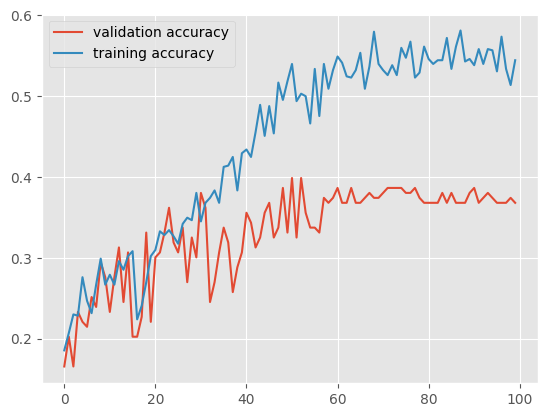

In [103]:
plt.style.use('ggplot')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.plot(running_corrects_history, label='training accuracy')
plt.legend()

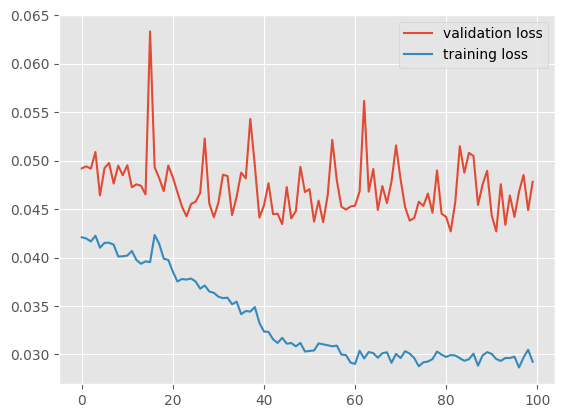

In [104]:
plt.style.use('ggplot')
plt.plot(val_running_loss_history, label='validation loss')
plt.plot(running_loss_history, label='training loss')

plt.legend()

In [105]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/gapminder_exp')

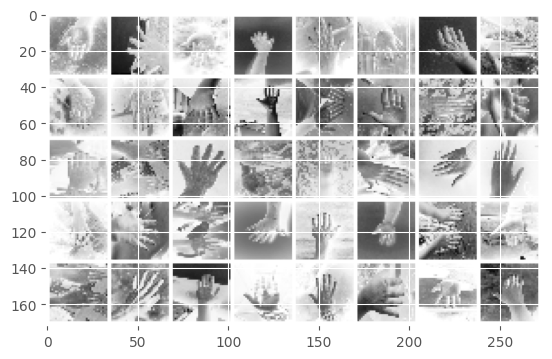

In [106]:
# берем рандомные изображения
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# создаем сетку изображений
img_grid = torchvision.utils.make_grid(images)

# показываем изображение
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('four_gapminder_images', img_grid)

In [108]:
# сохраняем обученную модель
! pip install onnx
torch.onnx.export(model, [x for x, y in val_dataloader][0], 'custom_gap.onnx', input_names=["images"], output_names=["wages"])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 64.3 MB/s eta 0:00:00
============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



### fine-tuning

In [ ]:
# import pytorch_lightning as pl
# from torchmetrics.functional import MSE
from torchvision.models import vgg16, efficientnet_b0, resnet50
from torchvision.models.inception import inception_v3

In [109]:
ft_model = resnet50(pretrained=True)
ft_model.fc = nn.Linear(2048, 10)

for param in ft_model.parameters():
               param.requires_grad = False

opt = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.005)
# opt = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(opt, gamma=0.1, step_size=20)

In [110]:
num_epochs = 100
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

# loss_func = nn.HuberLoss(delta=1.0)
# loss_func = compute_loss
loss_func = nn.CrossEntropyLoss()

for epoch in range(num_epochs):

    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    total_acc_train = 0
    total_loss_train = 0
    start_time = time.time()
    ft_model.train(True) # enable dropout / batch_norm training behavior
    for x_train, y_train in tqdm(train_dataloader):
        # train on batch
        # x_train = train_transforms(np.array(x_train))
        # x_train = normaliser(x_train)

        # x_train = torch.reshape(x_train,(1,3, 32, 32))
        outputs = ft_model(x_train)
        # print(outputs)
        # loss = compute_loss(y_train, outputs)
        outputs = torch.squeeze(outputs, 0)
        loss = loss_func(outputs, y_train.long())
        loss.requires_grad = True
        loss.backward()
        opt.step()
        opt.zero_grad()
        # _, preds = torch.max(outputs, 0) # taking the highest value of prediction.
        running_loss += loss.item()
        acc = (outputs.argmax(dim=1) == y_train).sum().item()
        total_acc_train += acc
        # running_corrects += torch.sum(preds == y_train.data)
    # And a full pass over the validation data:
    total_acc_val = 0
    total_loss_val = 0
    ft_model.train(False) # disable dropout / use averages for batch_norm
    with torch.no_grad():
      for x_val, y_val in tqdm(val_dataloader):
          # x_val = test_transforms(x_val)
          # x_val = torch.reshape(x_val,(50,3, 32, 32))
          # y_val = y_val
          y_out = ft_model(x_val)
          y_out = torch.squeeze(y_out, 0)
          val_loss = loss_func(y_out, y_val.long())
          # val_loss = compute_loss(y_val, y_out)
          _, y_pred = torch.max(y_out, 0)
          val_running_loss += val_loss.item()
          # val_running_corrects += torch.sum(y_pred == y_val.data)
          acc = (y_out.argmax(dim=1) == y_val).sum().item()
          total_acc_val += acc
    scheduler.step()

    epoch_loss = running_loss/len(X_train) # loss per epoch
    # epoch_acc = running_corrects.float()/ len(X_train) # accuracy per epoch
    running_loss_history.append(epoch_loss) # appending for displaying
    running_corrects_history.append(total_acc_train / len(train_set))

    val_epoch_loss = val_running_loss/len(X_test)
    # val_epoch_acc = val_running_corrects.float()/len(X_test)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(total_acc_val / len(val_set))
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print('epoch :', (epoch+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, total_acc_train / len(train_set)))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, total_acc_val / len(val_set)))

100%|██████████| 5/5 [00:00<00:00,  6.99it/s]


Epoch 1 of 100 took 4.864s
epoch : 1
training loss: 0.0618, acc 0.1120 
validation loss: 0.0711, validation acc 0.1411 


100%|██████████| 5/5 [00:00<00:00,  6.92it/s]


Epoch 2 of 100 took 3.981s
epoch : 2
training loss: 0.0621, acc 0.1104 
validation loss: 0.0723, validation acc 0.1534 


100%|██████████| 5/5 [00:01<00:00,  4.66it/s]


Epoch 3 of 100 took 4.364s
epoch : 3
training loss: 0.0626, acc 0.0982 
validation loss: 0.0723, validation acc 0.1166 


100%|██████████| 5/5 [00:01<00:00,  4.81it/s]


Epoch 4 of 100 took 8.367s
epoch : 4
training loss: 0.0624, acc 0.0920 
validation loss: 0.0731, validation acc 0.1595 


100%|██████████| 5/5 [00:00<00:00,  6.84it/s]


Epoch 5 of 100 took 5.535s
epoch : 5
training loss: 0.0621, acc 0.1028 
validation loss: 0.0735, validation acc 0.1350 


100%|██████████| 5/5 [00:00<00:00,  6.07it/s]


Epoch 6 of 100 took 4.784s
epoch : 6
training loss: 0.0622, acc 0.1028 
validation loss: 0.0698, validation acc 0.1227 


100%|██████████| 5/5 [00:00<00:00,  6.61it/s]


Epoch 7 of 100 took 3.986s
epoch : 7
training loss: 0.0620, acc 0.1012 
validation loss: 0.0709, validation acc 0.1411 


100%|██████████| 5/5 [00:00<00:00,  6.97it/s]


Epoch 8 of 100 took 3.963s
epoch : 8
training loss: 0.0619, acc 0.1058 
validation loss: 0.0728, validation acc 0.1227 


100%|██████████| 5/5 [00:00<00:00,  5.59it/s]


Epoch 9 of 100 took 4.539s
epoch : 9
training loss: 0.0623, acc 0.1104 
validation loss: 0.0727, validation acc 0.1472 


100%|██████████| 5/5 [00:00<00:00,  7.03it/s]


Epoch 10 of 100 took 3.993s
epoch : 10
training loss: 0.0627, acc 0.1120 
validation loss: 0.0707, validation acc 0.1411 


100%|██████████| 5/5 [00:00<00:00,  6.78it/s]


Epoch 11 of 100 took 4.005s
epoch : 11
training loss: 0.0617, acc 0.1181 
validation loss: 0.0723, validation acc 0.1227 


100%|██████████| 5/5 [00:00<00:00,  5.42it/s]


Epoch 12 of 100 took 4.321s
epoch : 12
training loss: 0.0623, acc 0.1012 
validation loss: 0.0744, validation acc 0.1166 


100%|██████████| 5/5 [00:00<00:00,  6.75it/s]


Epoch 13 of 100 took 4.339s
epoch : 13
training loss: 0.0625, acc 0.1135 
validation loss: 0.0733, validation acc 0.1288 


100%|██████████| 5/5 [00:00<00:00,  6.82it/s]


Epoch 14 of 100 took 4.011s
epoch : 14
training loss: 0.0621, acc 0.1150 
validation loss: 0.0717, validation acc 0.1472 


100%|██████████| 5/5 [00:00<00:00,  5.83it/s]


Epoch 15 of 100 took 4.140s
epoch : 15
training loss: 0.0625, acc 0.1104 
validation loss: 0.0729, validation acc 0.1350 


100%|██████████| 5/5 [00:00<00:00,  6.67it/s]


Epoch 16 of 100 took 4.606s
epoch : 16
training loss: 0.0621, acc 0.1273 
validation loss: 0.0763, validation acc 0.1104 


100%|██████████| 5/5 [00:00<00:00,  6.91it/s]


Epoch 17 of 100 took 3.955s
epoch : 17
training loss: 0.0624, acc 0.0936 
validation loss: 0.0688, validation acc 0.1166 


100%|██████████| 5/5 [00:00<00:00,  6.94it/s]


Epoch 18 of 100 took 3.988s
epoch : 18
training loss: 0.0620, acc 0.0951 
validation loss: 0.0746, validation acc 0.1166 


100%|██████████| 5/5 [00:00<00:00,  6.88it/s]


Epoch 19 of 100 took 4.778s
epoch : 19
training loss: 0.0622, acc 0.1212 
validation loss: 0.0703, validation acc 0.1350 


100%|██████████| 5/5 [00:00<00:00,  6.89it/s]


Epoch 20 of 100 took 3.949s
epoch : 20
training loss: 0.0618, acc 0.1120 
validation loss: 0.0708, validation acc 0.1472 


100%|██████████| 5/5 [00:00<00:00,  6.77it/s]


Epoch 21 of 100 took 3.931s
epoch : 21
training loss: 0.0630, acc 0.0982 
validation loss: 0.0741, validation acc 0.1043 


100%|██████████| 5/5 [00:00<00:00,  5.56it/s]


Epoch 22 of 100 took 4.776s
epoch : 22
training loss: 0.0628, acc 0.1150 
validation loss: 0.0728, validation acc 0.1350 


100%|██████████| 5/5 [00:00<00:00,  6.80it/s]


Epoch 23 of 100 took 3.980s
epoch : 23
training loss: 0.0625, acc 0.1058 
validation loss: 0.0745, validation acc 0.1166 


100%|██████████| 5/5 [00:01<00:00,  4.81it/s]


Epoch 24 of 100 took 4.611s
epoch : 24
training loss: 0.0622, acc 0.0874 
validation loss: 0.0727, validation acc 0.1472 


100%|██████████| 5/5 [00:00<00:00,  5.45it/s]


Epoch 25 of 100 took 4.610s
epoch : 25
training loss: 0.0625, acc 0.0966 
validation loss: 0.0732, validation acc 0.1288 


100%|██████████| 5/5 [00:00<00:00,  5.92it/s]


Epoch 26 of 100 took 4.088s
epoch : 26
training loss: 0.0626, acc 0.0844 
validation loss: 0.0715, validation acc 0.1227 


100%|██████████| 5/5 [00:00<00:00,  6.84it/s]


Epoch 27 of 100 took 4.718s
epoch : 27
training loss: 0.0622, acc 0.1074 
validation loss: 0.0730, validation acc 0.1595 


100%|██████████| 5/5 [00:00<00:00,  5.47it/s]


Epoch 28 of 100 took 4.665s
epoch : 28
training loss: 0.0621, acc 0.1028 
validation loss: 0.0724, validation acc 0.1288 


100%|██████████| 5/5 [00:00<00:00,  6.60it/s]


Epoch 29 of 100 took 4.019s
epoch : 29
training loss: 0.0622, acc 0.0936 
validation loss: 0.0727, validation acc 0.1350 


100%|██████████| 5/5 [00:00<00:00,  6.84it/s]


Epoch 30 of 100 took 3.879s
epoch : 30
training loss: 0.0622, acc 0.1043 
validation loss: 0.0735, validation acc 0.1411 


100%|██████████| 5/5 [00:00<00:00,  5.62it/s]


Epoch 31 of 100 took 4.285s
epoch : 31
training loss: 0.0622, acc 0.1104 
validation loss: 0.0727, validation acc 0.1288 


100%|██████████| 5/5 [00:00<00:00,  6.87it/s]


Epoch 32 of 100 took 4.312s
epoch : 32
training loss: 0.0624, acc 0.1028 
validation loss: 0.0718, validation acc 0.1350 


100%|██████████| 5/5 [00:00<00:00,  6.73it/s]


Epoch 33 of 100 took 3.992s
epoch : 33
training loss: 0.0624, acc 0.1166 
validation loss: 0.0723, validation acc 0.1350 


100%|██████████| 5/5 [00:00<00:00,  5.55it/s]


Epoch 34 of 100 took 4.071s
epoch : 34
training loss: 0.0621, acc 0.1104 
validation loss: 0.0711, validation acc 0.1411 


100%|██████████| 5/5 [00:00<00:00,  6.72it/s]


Epoch 35 of 100 took 4.544s
epoch : 35
training loss: 0.0620, acc 0.1012 
validation loss: 0.0720, validation acc 0.1350 


100%|██████████| 5/5 [00:00<00:00,  6.84it/s]


Epoch 36 of 100 took 3.980s
epoch : 36
training loss: 0.0619, acc 0.1058 
validation loss: 0.0723, validation acc 0.1472 


100%|██████████| 5/5 [00:00<00:00,  7.04it/s]


Epoch 37 of 100 took 3.844s
epoch : 37
training loss: 0.0625, acc 0.0920 
validation loss: 0.0720, validation acc 0.1227 


100%|██████████| 5/5 [00:00<00:00,  6.64it/s]


Epoch 38 of 100 took 4.861s
epoch : 38
training loss: 0.0625, acc 0.0966 
validation loss: 0.0730, validation acc 0.1166 


100%|██████████| 5/5 [00:00<00:00,  6.88it/s]


Epoch 39 of 100 took 3.997s
epoch : 39
training loss: 0.0617, acc 0.1150 
validation loss: 0.0703, validation acc 0.1534 


100%|██████████| 5/5 [00:00<00:00,  6.89it/s]


Epoch 40 of 100 took 3.911s
epoch : 40
training loss: 0.0622, acc 0.0997 
validation loss: 0.0715, validation acc 0.1350 


100%|██████████| 5/5 [00:00<00:00,  5.63it/s]


Epoch 41 of 100 took 4.769s
epoch : 41
training loss: 0.0621, acc 0.1166 
validation loss: 0.0734, validation acc 0.1227 


100%|██████████| 5/5 [00:00<00:00,  6.86it/s]


Epoch 42 of 100 took 3.975s
epoch : 42
training loss: 0.0625, acc 0.0951 
validation loss: 0.0709, validation acc 0.1227 


100%|██████████| 5/5 [00:00<00:00,  6.94it/s]


Epoch 43 of 100 took 3.920s
epoch : 43
training loss: 0.0624, acc 0.1104 
validation loss: 0.0715, validation acc 0.1534 


100%|██████████| 5/5 [00:00<00:00,  5.45it/s]


Epoch 44 of 100 took 4.583s
epoch : 44
training loss: 0.0621, acc 0.0966 
validation loss: 0.0736, validation acc 0.1411 


100%|██████████| 5/5 [00:00<00:00,  6.69it/s]


Epoch 45 of 100 took 4.125s
epoch : 45
training loss: 0.0625, acc 0.1104 
validation loss: 0.0746, validation acc 0.1227 


100%|██████████| 5/5 [00:00<00:00,  6.86it/s]


Epoch 46 of 100 took 3.998s
epoch : 46
training loss: 0.0630, acc 0.1074 
validation loss: 0.0723, validation acc 0.1411 


100%|██████████| 5/5 [00:00<00:00,  5.48it/s]


Epoch 47 of 100 took 4.355s
epoch : 47
training loss: 0.0624, acc 0.0997 
validation loss: 0.0733, validation acc 0.1534 


100%|██████████| 5/5 [00:00<00:00,  6.79it/s]


Epoch 48 of 100 took 4.387s
epoch : 48
training loss: 0.0620, acc 0.1227 
validation loss: 0.0724, validation acc 0.1227 


100%|██████████| 5/5 [00:00<00:00,  7.37it/s]


Epoch 49 of 100 took 3.879s
epoch : 49
training loss: 0.0626, acc 0.0890 
validation loss: 0.0705, validation acc 0.1288 


100%|██████████| 5/5 [00:00<00:00,  5.96it/s]


Epoch 50 of 100 took 4.114s
epoch : 50
training loss: 0.0622, acc 0.1089 
validation loss: 0.0737, validation acc 0.1104 


100%|██████████| 5/5 [00:00<00:00,  6.98it/s]


Epoch 51 of 100 took 4.543s
epoch : 51
training loss: 0.0619, acc 0.1288 
validation loss: 0.0697, validation acc 0.1350 


100%|██████████| 5/5 [00:00<00:00,  7.06it/s]


Epoch 52 of 100 took 3.877s
epoch : 52
training loss: 0.0627, acc 0.1074 
validation loss: 0.0732, validation acc 0.1227 


100%|██████████| 5/5 [00:00<00:00,  6.78it/s]


Epoch 53 of 100 took 3.977s
epoch : 53
training loss: 0.0622, acc 0.1135 
validation loss: 0.0708, validation acc 0.1411 


100%|██████████| 5/5 [00:00<00:00,  7.01it/s]


Epoch 54 of 100 took 4.722s
epoch : 54
training loss: 0.0621, acc 0.1074 
validation loss: 0.0687, validation acc 0.1411 


100%|██████████| 5/5 [00:00<00:00,  6.89it/s]


Epoch 55 of 100 took 4.021s
epoch : 55
training loss: 0.0621, acc 0.1028 
validation loss: 0.0733, validation acc 0.1227 


100%|██████████| 5/5 [00:00<00:00,  6.84it/s]


Epoch 56 of 100 took 3.974s
epoch : 56
training loss: 0.0622, acc 0.0936 
validation loss: 0.0744, validation acc 0.1227 


100%|██████████| 5/5 [00:00<00:00,  5.21it/s]


Epoch 57 of 100 took 4.774s
epoch : 57
training loss: 0.0617, acc 0.1074 
validation loss: 0.0731, validation acc 0.1166 


100%|██████████| 5/5 [00:00<00:00,  6.74it/s]


Epoch 58 of 100 took 3.938s
epoch : 58
training loss: 0.0622, acc 0.1058 
validation loss: 0.0699, validation acc 0.0920 


100%|██████████| 5/5 [00:00<00:00,  6.82it/s]


Epoch 59 of 100 took 3.945s
epoch : 59
training loss: 0.0622, acc 0.1028 
validation loss: 0.0728, validation acc 0.1472 


100%|██████████| 5/5 [00:00<00:00,  5.71it/s]


Epoch 60 of 100 took 4.394s
epoch : 60
training loss: 0.0622, acc 0.1104 
validation loss: 0.0714, validation acc 0.1472 


100%|██████████| 5/5 [00:00<00:00,  6.79it/s]


Epoch 61 of 100 took 4.294s
epoch : 61
training loss: 0.0625, acc 0.0905 
validation loss: 0.0733, validation acc 0.1534 


100%|██████████| 5/5 [00:00<00:00,  7.05it/s]


Epoch 62 of 100 took 4.044s
epoch : 62
training loss: 0.0624, acc 0.1058 
validation loss: 0.0695, validation acc 0.1411 


100%|██████████| 5/5 [00:00<00:00,  5.50it/s]


Epoch 63 of 100 took 4.411s
epoch : 63
training loss: 0.0620, acc 0.1120 
validation loss: 0.0727, validation acc 0.1227 


100%|██████████| 5/5 [00:00<00:00,  6.90it/s]


Epoch 64 of 100 took 4.361s
epoch : 64
training loss: 0.0620, acc 0.1043 
validation loss: 0.0704, validation acc 0.1595 


100%|██████████| 5/5 [00:00<00:00,  6.99it/s]


Epoch 65 of 100 took 4.032s
epoch : 65
training loss: 0.0626, acc 0.1012 
validation loss: 0.0729, validation acc 0.1411 


100%|██████████| 5/5 [00:00<00:00,  6.26it/s]


Epoch 66 of 100 took 3.984s
epoch : 66
training loss: 0.0621, acc 0.1028 
validation loss: 0.0721, validation acc 0.1350 


100%|██████████| 5/5 [00:00<00:00,  7.03it/s]


Epoch 67 of 100 took 4.531s
epoch : 67
training loss: 0.0623, acc 0.1089 
validation loss: 0.0717, validation acc 0.1534 


100%|██████████| 5/5 [00:00<00:00,  5.59it/s]


Epoch 68 of 100 took 4.131s
epoch : 68
training loss: 0.0621, acc 0.1074 
validation loss: 0.0750, validation acc 0.1411 


100%|██████████| 5/5 [00:00<00:00,  5.96it/s]


Epoch 69 of 100 took 4.646s
epoch : 69
training loss: 0.0626, acc 0.1104 
validation loss: 0.0731, validation acc 0.1166 


100%|██████████| 5/5 [00:00<00:00,  6.80it/s]


Epoch 70 of 100 took 4.617s
epoch : 70
training loss: 0.0620, acc 0.1150 
validation loss: 0.0699, validation acc 0.1288 


100%|██████████| 5/5 [00:00<00:00,  6.98it/s]


Epoch 71 of 100 took 3.984s
epoch : 71
training loss: 0.0620, acc 0.1104 
validation loss: 0.0722, validation acc 0.1595 


100%|██████████| 5/5 [00:00<00:00,  6.85it/s]


Epoch 72 of 100 took 3.937s
epoch : 72
training loss: 0.0621, acc 0.1181 
validation loss: 0.0694, validation acc 0.1472 


100%|██████████| 5/5 [00:00<00:00,  6.64it/s]


Epoch 73 of 100 took 4.771s
epoch : 73
training loss: 0.0622, acc 0.0997 
validation loss: 0.0710, validation acc 0.1472 


100%|██████████| 5/5 [00:00<00:00,  6.93it/s]


Epoch 74 of 100 took 3.951s
epoch : 74
training loss: 0.0620, acc 0.1089 
validation loss: 0.0714, validation acc 0.1350 


100%|██████████| 5/5 [00:00<00:00,  6.69it/s]


Epoch 75 of 100 took 3.974s
epoch : 75
training loss: 0.0623, acc 0.1212 
validation loss: 0.0724, validation acc 0.1288 


100%|██████████| 5/5 [00:00<00:00,  5.57it/s]


Epoch 76 of 100 took 4.668s
epoch : 76
training loss: 0.0618, acc 0.1074 
validation loss: 0.0707, validation acc 0.1472 


100%|██████████| 5/5 [00:00<00:00,  6.80it/s]


Epoch 77 of 100 took 4.001s
epoch : 77
training loss: 0.0622, acc 0.1012 
validation loss: 0.0731, validation acc 0.1288 


100%|██████████| 5/5 [00:00<00:00,  7.14it/s]


Epoch 78 of 100 took 3.928s
epoch : 78
training loss: 0.0624, acc 0.1104 
validation loss: 0.0739, validation acc 0.1104 


100%|██████████| 5/5 [00:00<00:00,  5.30it/s]


Epoch 79 of 100 took 4.460s
epoch : 79
training loss: 0.0621, acc 0.1012 
validation loss: 0.0718, validation acc 0.1288 


100%|██████████| 5/5 [00:00<00:00,  6.75it/s]


Epoch 80 of 100 took 4.241s
epoch : 80
training loss: 0.0622, acc 0.1028 
validation loss: 0.0716, validation acc 0.1595 


100%|██████████| 5/5 [00:00<00:00,  6.82it/s]


Epoch 81 of 100 took 4.027s
epoch : 81
training loss: 0.0621, acc 0.0997 
validation loss: 0.0736, validation acc 0.1288 


100%|██████████| 5/5 [00:00<00:00,  5.37it/s]


Epoch 82 of 100 took 4.082s
epoch : 82
training loss: 0.0619, acc 0.1120 
validation loss: 0.0735, validation acc 0.1350 


100%|██████████| 5/5 [00:00<00:00,  6.86it/s]


Epoch 83 of 100 took 4.581s
epoch : 83
training loss: 0.0621, acc 0.0905 
validation loss: 0.0742, validation acc 0.1227 


100%|██████████| 5/5 [00:00<00:00,  6.58it/s]


Epoch 84 of 100 took 4.069s
epoch : 84
training loss: 0.0625, acc 0.0966 
validation loss: 0.0733, validation acc 0.1227 


100%|██████████| 5/5 [00:00<00:00,  6.69it/s]


Epoch 85 of 100 took 3.973s
epoch : 85
training loss: 0.0627, acc 0.1012 
validation loss: 0.0716, validation acc 0.1472 


100%|██████████| 5/5 [00:00<00:00,  6.81it/s]


Epoch 86 of 100 took 4.739s
epoch : 86
training loss: 0.0628, acc 0.1028 
validation loss: 0.0728, validation acc 0.1350 


100%|██████████| 5/5 [00:00<00:00,  6.67it/s]


Epoch 87 of 100 took 4.031s
epoch : 87
training loss: 0.0620, acc 0.1135 
validation loss: 0.0724, validation acc 0.1534 


100%|██████████| 5/5 [00:00<00:00,  6.91it/s]


Epoch 88 of 100 took 3.942s
epoch : 88
training loss: 0.0619, acc 0.1089 
validation loss: 0.0729, validation acc 0.1227 


100%|██████████| 5/5 [00:00<00:00,  6.42it/s]


Epoch 89 of 100 took 4.794s
epoch : 89
training loss: 0.0620, acc 0.0951 
validation loss: 0.0689, validation acc 0.1288 


100%|██████████| 5/5 [00:00<00:00,  7.00it/s]


Epoch 90 of 100 took 4.021s
epoch : 90
training loss: 0.0621, acc 0.1043 
validation loss: 0.0720, validation acc 0.1227 


100%|██████████| 5/5 [00:00<00:00,  6.62it/s]


Epoch 91 of 100 took 3.943s
epoch : 91
training loss: 0.0623, acc 0.1150 
validation loss: 0.0718, validation acc 0.1534 


100%|██████████| 5/5 [00:00<00:00,  5.66it/s]


Epoch 92 of 100 took 4.558s
epoch : 92
training loss: 0.0623, acc 0.1089 
validation loss: 0.0705, validation acc 0.1288 


100%|██████████| 5/5 [00:00<00:00,  6.75it/s]


Epoch 93 of 100 took 4.029s
epoch : 93
training loss: 0.0623, acc 0.1150 
validation loss: 0.0712, validation acc 0.1227 


100%|██████████| 5/5 [00:00<00:00,  6.66it/s]


Epoch 94 of 100 took 4.021s
epoch : 94
training loss: 0.0622, acc 0.1043 
validation loss: 0.0745, validation acc 0.1227 


100%|██████████| 5/5 [00:00<00:00,  5.45it/s]


Epoch 95 of 100 took 4.365s
epoch : 95
training loss: 0.0623, acc 0.1181 
validation loss: 0.0725, validation acc 0.1166 


100%|██████████| 5/5 [00:00<00:00,  6.31it/s]


Epoch 96 of 100 took 4.418s
epoch : 96
training loss: 0.0625, acc 0.0828 
validation loss: 0.0766, validation acc 0.1288 


100%|██████████| 5/5 [00:00<00:00,  6.79it/s]


Epoch 97 of 100 took 3.974s
epoch : 97
training loss: 0.0623, acc 0.1396 
validation loss: 0.0726, validation acc 0.1288 


100%|██████████| 5/5 [00:00<00:00,  5.56it/s]


Epoch 98 of 100 took 4.081s
epoch : 98
training loss: 0.0626, acc 0.0982 
validation loss: 0.0719, validation acc 0.1227 


100%|██████████| 5/5 [00:00<00:00,  7.00it/s]


Epoch 99 of 100 took 4.565s
epoch : 99
training loss: 0.0618, acc 0.1135 
validation loss: 0.0718, validation acc 0.1350 


100%|██████████| 5/5 [00:00<00:00,  6.75it/s]

Epoch 100 of 100 took 3.853s
epoch : 100
training loss: 0.0623, acc 0.1058 
validation loss: 0.0711, validation acc 0.1227 


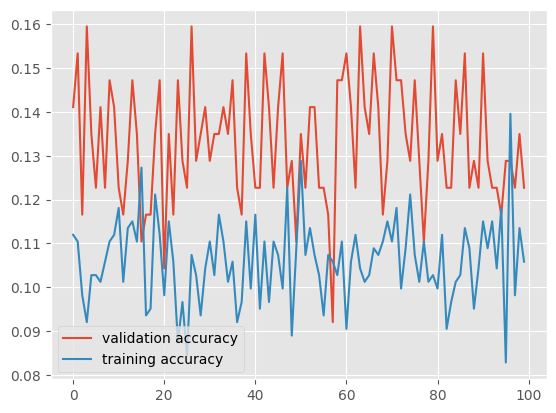

In [111]:
plt.style.use('ggplot')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.plot(running_corrects_history, label='training accuracy')
plt.legend()

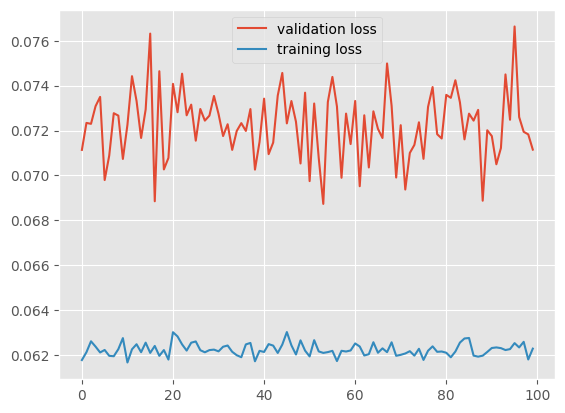

In [112]:
plt.style.use('ggplot')
plt.plot(val_running_loss_history, label='validation loss')
plt.plot(running_loss_history, label='training loss')

plt.legend()

In [113]:
# сохраняем обученную модель

torch.onnx.export(ft_model, [x for x, y in val_dataloader][0], 'ft_gap.onnx', input_names=["images"], output_names=["wages"])

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [ ]:
###

### Обучение модели на изображениях зубов

In [114]:
labels_teeth = np.load('drive/MyDrive/teeth_labels.npy', allow_pickle=True)
images_teeth = np.load('drive/MyDrive/teeth_images.npy', allow_pickle=True)

im_list_teeth = [resize(torch.as_tensor(im, dtype=torch.float32), (224, 224)) for im in images_teeth]
label_list_teeth = [torch.as_tensor(l-1, dtype=torch.float32) for l in labels_teeth]

In [121]:
X_train, X_test, Y_train, Y_test = train_test_split(im_list_teeth, label_list_teeth, test_size=0.2, random_state=42)

print("Train size = ", len(X_train))
print("Validation size = ", len(X_test))

Train size =  297
Validation size =  75


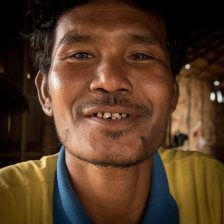

In [122]:
# удаляем фото, несоответствующие размерности
X_test = [photo for photo in X_test if photo.shape == (224, 224, 3)]
X_train = [photo for photo in X_train if photo.shape == (224, 224, 3)]
result = Image.fromarray(np.array(X_train[0]).astype(np.uint8))
result.convert('RGB')

In [123]:
model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=10, kernel_size=5),
    nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3),
    nn.BatchNorm2d(20),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(3380, 3000),
    nn.ReLU(),
    nn.Linear(3000, 2500),
    nn.ReLU(),
    nn.Linear(2500, 2000),
    nn.Tanh(),
    nn.Linear(2000, 1500),
    nn.ReLU(),
    nn.Linear(1500, 1000),
    nn.Tanh(),
    nn.Linear(1000, 500),
    nn.ReLU(),
    nn.Linear(500, 100),
    nn.Linear(100, 5),
    nn.Dropout(0.3)
)

opt = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.005)
# opt = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(opt, gamma=0.1, step_size=20)

In [124]:
train_transforms = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.ColorJitter(),
                                transforms.RandomCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.Resize((32,32)),
                                transforms.Normalize(mean=(0.5,), std=(0.5,))])

test_transforms = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Resize((32,32)),
                                transforms.Normalize(mean=(0.5,), std=(0.5,))])

In [125]:
dataset = [[i,j] for i, j in zip(im_list, label_list) if i.shape == (224, 224, 3)]

train_set, val_set = torch.utils.data.random_split(
    dataset,
    [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))]
)

train_set = [[torch.transpose(train_transforms(pic[0]), 2,1), pic[1]] for pic in train_set]
val_set = [[torch.transpose(test_transforms(pic[0]), 2,1), pic[1]] for pic in val_set]

train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=40, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=40, shuffle=True)

In [126]:
num_epochs = 100
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

# loss_func = nn.HuberLoss(delta=1.0)
# loss_func = compute_loss
loss_func = nn.CrossEntropyLoss()

for epoch in range(num_epochs):

    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    total_acc_train = 0
    total_loss_train = 0
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for x_train, y_train in tqdm(train_dataloader):
        # train on batch
        # x_train = train_transforms(np.array(x_train))
        # x_train = normaliser(x_train)

        # x_train = torch.reshape(x_train,(1,3, 32, 32))
        outputs = model(x_train)
        # print(outputs)
        # loss = compute_loss(y_train, outputs)
        outputs = torch.squeeze(outputs, 0)
        loss = F.cross_entropy(outputs, y_train.long())
        loss.backward()
        opt.step()
        opt.zero_grad()
        # _, preds = torch.max(outputs, 0) # taking the highest value of prediction.
        running_loss += loss.item()
        acc = (outputs.argmax(dim=1) == y_train).sum().item()
        total_acc_train += acc
        # running_corrects += torch.sum(preds == y_train.data)
    # And a full pass over the validation data:
    total_acc_val = 0
    total_loss_val = 0
    model.train(False) # disable dropout / use averages for batch_norm
    with torch.no_grad():
      for x_val, y_val in tqdm(val_dataloader):
          # x_val = test_transforms(x_val)
          # x_val = torch.reshape(x_val,(50,3, 32, 32))
          # y_val = y_val
          y_out = model(x_val)
          y_out = torch.squeeze(y_out, 0)
          val_loss = F.cross_entropy(y_out, y_val.long())
          # val_loss = compute_loss(y_val, y_out)
          _, y_pred = torch.max(y_out, 0)
          val_running_loss += val_loss.item()
          # val_running_corrects += torch.sum(y_pred == y_val.data)
          acc = (y_out.argmax(dim=1) == y_val).sum().item()
          total_acc_val += acc
    scheduler.step()

    epoch_loss = running_loss/len(X_train) # loss per epoch
    # epoch_acc = running_corrects.float()/ len(X_train) # accuracy per epoch
    running_loss_history.append(epoch_loss) # appending for displaying
    running_corrects_history.append(total_acc_train / len(train_set))

    val_epoch_loss = val_running_loss/len(X_test)
    # val_epoch_acc = val_running_corrects.float()/len(X_test)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(total_acc_val / len(val_set))
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print('epoch :', (epoch+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, total_acc_train / len(train_set)))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, total_acc_val / len(val_set)))

100%|██████████| 5/5 [00:00<00:00, 24.06it/s]


Epoch 1 of 100 took 3.559s
epoch : 1
training loss: 0.0925, acc 0.2055 
validation loss: 0.1068, validation acc 0.2454 


100%|██████████| 5/5 [00:00<00:00, 19.89it/s]


Epoch 2 of 100 took 3.943s
epoch : 2
training loss: 0.0922, acc 0.2239 
validation loss: 0.1062, validation acc 0.2086 


100%|██████████| 5/5 [00:00<00:00, 24.03it/s]


Epoch 3 of 100 took 3.623s
epoch : 3
training loss: 0.0902, acc 0.2561 
validation loss: 0.1053, validation acc 0.2638 


100%|██████████| 5/5 [00:00<00:00, 25.11it/s]


Epoch 4 of 100 took 3.426s
epoch : 4
training loss: 0.0905, acc 0.2822 
validation loss: 0.1071, validation acc 0.2086 


100%|██████████| 5/5 [00:00<00:00, 24.12it/s]


Epoch 5 of 100 took 3.425s
epoch : 5
training loss: 0.0905, acc 0.2899 
validation loss: 0.1081, validation acc 0.2393 


100%|██████████| 5/5 [00:00<00:00, 25.28it/s]


Epoch 6 of 100 took 4.004s
epoch : 6
training loss: 0.0900, acc 0.2623 
validation loss: 0.1279, validation acc 0.1718 


100%|██████████| 5/5 [00:00<00:00, 24.69it/s]


Epoch 7 of 100 took 3.424s
epoch : 7
training loss: 0.0894, acc 0.2791 
validation loss: 0.1027, validation acc 0.2331 


100%|██████████| 5/5 [00:00<00:00, 24.26it/s]


Epoch 8 of 100 took 3.424s
epoch : 8
training loss: 0.0893, acc 0.2730 
validation loss: 0.1055, validation acc 0.3006 


100%|██████████| 5/5 [00:00<00:00, 19.54it/s]


Epoch 9 of 100 took 3.716s
epoch : 9
training loss: 0.0880, acc 0.2730 
validation loss: 0.1027, validation acc 0.2638 


100%|██████████| 5/5 [00:00<00:00, 23.84it/s]


Epoch 10 of 100 took 3.842s
epoch : 10
training loss: 0.0864, acc 0.3067 
validation loss: 0.1072, validation acc 0.2086 


100%|██████████| 5/5 [00:00<00:00, 22.58it/s]


Epoch 11 of 100 took 3.434s
epoch : 11
training loss: 0.0867, acc 0.2822 
validation loss: 0.1073, validation acc 0.2086 


100%|██████████| 5/5 [00:00<00:00, 23.29it/s]


Epoch 12 of 100 took 3.536s
epoch : 12
training loss: 0.0877, acc 0.2914 
validation loss: 0.1097, validation acc 0.2577 


100%|██████████| 5/5 [00:00<00:00, 18.55it/s]


Epoch 13 of 100 took 4.148s
epoch : 13
training loss: 0.0921, acc 0.2408 
validation loss: 0.1061, validation acc 0.2086 


100%|██████████| 5/5 [00:00<00:00, 25.04it/s]


Epoch 14 of 100 took 3.479s
epoch : 14
training loss: 0.0908, acc 0.2531 
validation loss: 0.1367, validation acc 0.1779 


100%|██████████| 5/5 [00:00<00:00, 24.64it/s]


Epoch 15 of 100 took 3.516s
epoch : 15
training loss: 0.0874, acc 0.3298 
validation loss: 0.1067, validation acc 0.1963 


100%|██████████| 5/5 [00:00<00:00, 19.55it/s]


Epoch 16 of 100 took 3.623s
epoch : 16
training loss: 0.0906, acc 0.2623 
validation loss: 0.1083, validation acc 0.2515 


100%|██████████| 5/5 [00:00<00:00, 24.11it/s]


Epoch 17 of 100 took 3.996s
epoch : 17
training loss: 0.0908, acc 0.2883 
validation loss: 0.1057, validation acc 0.2638 


100%|██████████| 5/5 [00:00<00:00, 24.07it/s]


Epoch 18 of 100 took 3.475s
epoch : 18
training loss: 0.0884, acc 0.2684 
validation loss: 0.1030, validation acc 0.2577 


100%|██████████| 5/5 [00:00<00:00, 23.67it/s]


Epoch 19 of 100 took 3.487s
epoch : 19
training loss: 0.0856, acc 0.2761 
validation loss: 0.1057, validation acc 0.2638 


100%|██████████| 5/5 [00:00<00:00, 19.25it/s]


Epoch 20 of 100 took 3.879s
epoch : 20
training loss: 0.0858, acc 0.3129 
validation loss: 0.1039, validation acc 0.2577 


100%|██████████| 5/5 [00:00<00:00, 24.51it/s]


Epoch 21 of 100 took 3.739s
epoch : 21
training loss: 0.0822, acc 0.3482 
validation loss: 0.0992, validation acc 0.2577 


100%|██████████| 5/5 [00:00<00:00, 23.41it/s]


Epoch 22 of 100 took 3.522s
epoch : 22
training loss: 0.0827, acc 0.3160 
validation loss: 0.1017, validation acc 0.2454 


100%|██████████| 5/5 [00:00<00:00, 24.53it/s]


Epoch 23 of 100 took 3.533s
epoch : 23
training loss: 0.0812, acc 0.3344 
validation loss: 0.1112, validation acc 0.2393 


100%|██████████| 5/5 [00:00<00:00, 23.73it/s]


Epoch 24 of 100 took 4.112s
epoch : 24
training loss: 0.0802, acc 0.3512 
validation loss: 0.1021, validation acc 0.2515 


100%|██████████| 5/5 [00:00<00:00, 23.47it/s]


Epoch 25 of 100 took 3.500s
epoch : 25
training loss: 0.0792, acc 0.3574 
validation loss: 0.1110, validation acc 0.2945 


100%|██████████| 5/5 [00:00<00:00, 24.21it/s]


Epoch 26 of 100 took 3.466s
epoch : 26
training loss: 0.0792, acc 0.3558 
validation loss: 0.1055, validation acc 0.2945 


100%|██████████| 5/5 [00:00<00:00, 22.73it/s]


Epoch 27 of 100 took 6.524s
epoch : 27
training loss: 0.0794, acc 0.3482 
validation loss: 0.1025, validation acc 0.2822 


100%|██████████| 5/5 [00:00<00:00, 23.17it/s]


Epoch 28 of 100 took 3.561s
epoch : 28
training loss: 0.0783, acc 0.3620 
validation loss: 0.1106, validation acc 0.3006 


100%|██████████| 5/5 [00:00<00:00, 23.72it/s]


Epoch 29 of 100 took 3.438s
epoch : 29
training loss: 0.0773, acc 0.3420 
validation loss: 0.1334, validation acc 0.2086 


100%|██████████| 5/5 [00:00<00:00, 17.93it/s]


Epoch 30 of 100 took 3.730s
epoch : 30
training loss: 0.0778, acc 0.3896 
validation loss: 0.1007, validation acc 0.3252 


100%|██████████| 5/5 [00:00<00:00, 23.68it/s]


Epoch 31 of 100 took 3.886s
epoch : 31
training loss: 0.0777, acc 0.3543 
validation loss: 0.0996, validation acc 0.2577 


100%|██████████| 5/5 [00:00<00:00, 23.02it/s]


Epoch 32 of 100 took 3.538s
epoch : 32
training loss: 0.0788, acc 0.3420 
validation loss: 0.1064, validation acc 0.2699 


100%|██████████| 5/5 [00:00<00:00, 22.57it/s]


Epoch 33 of 100 took 3.560s
epoch : 33
training loss: 0.0762, acc 0.3850 
validation loss: 0.0979, validation acc 0.2454 


100%|██████████| 5/5 [00:00<00:00, 18.36it/s]


Epoch 34 of 100 took 4.117s
epoch : 34
training loss: 0.0743, acc 0.4095 
validation loss: 0.1019, validation acc 0.2638 


100%|██████████| 5/5 [00:00<00:00, 22.32it/s]


Epoch 35 of 100 took 3.581s
epoch : 35
training loss: 0.0749, acc 0.3896 
validation loss: 0.1068, validation acc 0.2454 


100%|██████████| 5/5 [00:00<00:00, 22.91it/s]


Epoch 36 of 100 took 3.470s
epoch : 36
training loss: 0.0761, acc 0.3727 
validation loss: 0.1015, validation acc 0.2699 


100%|██████████| 5/5 [00:00<00:00, 19.59it/s]


Epoch 37 of 100 took 3.553s
epoch : 37
training loss: 0.0746, acc 0.3666 
validation loss: 0.1019, validation acc 0.2454 


100%|██████████| 5/5 [00:00<00:00, 24.09it/s]


Epoch 38 of 100 took 3.975s
epoch : 38
training loss: 0.0746, acc 0.3896 
validation loss: 0.1031, validation acc 0.2822 


100%|██████████| 5/5 [00:00<00:00, 20.87it/s]


Epoch 39 of 100 took 3.610s
epoch : 39
training loss: 0.0721, acc 0.3926 
validation loss: 0.1243, validation acc 0.2638 


100%|██████████| 5/5 [00:00<00:00, 23.53it/s]


Epoch 40 of 100 took 3.497s
epoch : 40
training loss: 0.0714, acc 0.3926 
validation loss: 0.1054, validation acc 0.2147 


100%|██████████| 5/5 [00:00<00:00, 18.83it/s]


Epoch 41 of 100 took 4.017s
epoch : 41
training loss: 0.0720, acc 0.4279 
validation loss: 0.1068, validation acc 0.2699 


100%|██████████| 5/5 [00:00<00:00, 25.35it/s]


Epoch 42 of 100 took 3.668s
epoch : 42
training loss: 0.0710, acc 0.4049 
validation loss: 0.1025, validation acc 0.2822 


100%|██████████| 5/5 [00:00<00:00, 18.46it/s]


Epoch 43 of 100 took 4.150s
epoch : 43
training loss: 0.0713, acc 0.4018 
validation loss: 0.1087, validation acc 0.2945 


100%|██████████| 5/5 [00:00<00:00, 17.30it/s]


Epoch 44 of 100 took 3.669s
epoch : 44
training loss: 0.0702, acc 0.4325 
validation loss: 0.1237, validation acc 0.2945 


100%|██████████| 5/5 [00:00<00:00, 23.78it/s]


Epoch 45 of 100 took 3.964s
epoch : 45
training loss: 0.0702, acc 0.4233 
validation loss: 0.0963, validation acc 0.2699 


100%|██████████| 5/5 [00:00<00:00, 23.63it/s]


Epoch 46 of 100 took 3.587s
epoch : 46
training loss: 0.0678, acc 0.4433 
validation loss: 0.1072, validation acc 0.2638 


100%|██████████| 5/5 [00:00<00:00, 23.89it/s]


Epoch 47 of 100 took 3.554s
epoch : 47
training loss: 0.0691, acc 0.4325 
validation loss: 0.0999, validation acc 0.2761 


100%|██████████| 5/5 [00:00<00:00, 19.42it/s]


Epoch 48 of 100 took 4.059s
epoch : 48
training loss: 0.0699, acc 0.3942 
validation loss: 0.1062, validation acc 0.2945 


100%|██████████| 5/5 [00:00<00:00, 23.66it/s]


Epoch 49 of 100 took 3.604s
epoch : 49
training loss: 0.0703, acc 0.4110 
validation loss: 0.0974, validation acc 0.2577 


100%|██████████| 5/5 [00:00<00:00, 23.48it/s]


Epoch 50 of 100 took 3.519s
epoch : 50
training loss: 0.0699, acc 0.4264 
validation loss: 0.0999, validation acc 0.2638 


100%|██████████| 5/5 [00:00<00:00, 18.92it/s]


Epoch 51 of 100 took 3.549s
epoch : 51
training loss: 0.0708, acc 0.4248 
validation loss: 0.1030, validation acc 0.2454 


100%|██████████| 5/5 [00:00<00:00, 23.51it/s]


Epoch 52 of 100 took 4.013s
epoch : 52
training loss: 0.0704, acc 0.4126 
validation loss: 0.1015, validation acc 0.2577 


100%|██████████| 5/5 [00:00<00:00, 23.39it/s]


Epoch 53 of 100 took 3.474s
epoch : 53
training loss: 0.0699, acc 0.4310 
validation loss: 0.1032, validation acc 0.2515 


100%|██████████| 5/5 [00:00<00:00, 23.77it/s]


Epoch 54 of 100 took 3.500s
epoch : 54
training loss: 0.0692, acc 0.4172 
validation loss: 0.1043, validation acc 0.2822 


100%|██████████| 5/5 [00:00<00:00, 18.73it/s]


Epoch 55 of 100 took 3.997s
epoch : 55
training loss: 0.0687, acc 0.4356 
validation loss: 0.1043, validation acc 0.2699 


100%|██████████| 5/5 [00:00<00:00, 24.44it/s]


Epoch 56 of 100 took 4.662s
epoch : 56
training loss: 0.0691, acc 0.4233 
validation loss: 0.1042, validation acc 0.2577 


100%|██████████| 5/5 [00:00<00:00, 23.84it/s]


Epoch 57 of 100 took 3.535s
epoch : 57
training loss: 0.0681, acc 0.4402 
validation loss: 0.1070, validation acc 0.2699 


100%|██████████| 5/5 [00:00<00:00, 18.68it/s]


Epoch 58 of 100 took 3.678s
epoch : 58
training loss: 0.0693, acc 0.4340 
validation loss: 0.1175, validation acc 0.2699 


100%|██████████| 5/5 [00:00<00:00, 23.17it/s]


Epoch 59 of 100 took 3.924s
epoch : 59
training loss: 0.0720, acc 0.3972 
validation loss: 0.1033, validation acc 0.2822 


100%|██████████| 5/5 [00:00<00:00, 23.85it/s]


Epoch 60 of 100 took 3.552s
epoch : 60
training loss: 0.0694, acc 0.4110 
validation loss: 0.1202, validation acc 0.2515 


100%|██████████| 5/5 [00:00<00:00, 23.03it/s]


Epoch 61 of 100 took 3.540s
epoch : 61
training loss: 0.0679, acc 0.4356 
validation loss: 0.1017, validation acc 0.2761 


100%|██████████| 5/5 [00:00<00:00, 20.12it/s]


Epoch 62 of 100 took 4.052s
epoch : 62
training loss: 0.0675, acc 0.4325 
validation loss: 0.0983, validation acc 0.2699 


100%|██████████| 5/5 [00:00<00:00, 22.89it/s]


Epoch 63 of 100 took 3.669s
epoch : 63
training loss: 0.0672, acc 0.4647 
validation loss: 0.1014, validation acc 0.2638 


100%|██████████| 5/5 [00:00<00:00, 21.73it/s]


Epoch 64 of 100 took 3.710s
epoch : 64
training loss: 0.0693, acc 0.4172 
validation loss: 0.1110, validation acc 0.2761 


100%|██████████| 5/5 [00:00<00:00, 19.63it/s]


Epoch 65 of 100 took 3.685s
epoch : 65
training loss: 0.0668, acc 0.4417 
validation loss: 0.1026, validation acc 0.2638 


100%|██████████| 5/5 [00:00<00:00, 23.75it/s]


Epoch 66 of 100 took 4.089s
epoch : 66
training loss: 0.0686, acc 0.4294 
validation loss: 0.0996, validation acc 0.2577 


100%|██████████| 5/5 [00:00<00:00, 23.89it/s]


Epoch 67 of 100 took 3.584s
epoch : 67
training loss: 0.0683, acc 0.4248 
validation loss: 0.1161, validation acc 0.2761 


100%|██████████| 5/5 [00:00<00:00, 24.21it/s]


Epoch 68 of 100 took 3.636s
epoch : 68
training loss: 0.0687, acc 0.4141 
validation loss: 0.1100, validation acc 0.2761 


100%|██████████| 5/5 [00:00<00:00, 18.26it/s]


Epoch 69 of 100 took 4.239s
epoch : 69
training loss: 0.0694, acc 0.4279 
validation loss: 0.1025, validation acc 0.2638 


100%|██████████| 5/5 [00:00<00:00, 22.25it/s]


Epoch 70 of 100 took 3.682s
epoch : 70
training loss: 0.0688, acc 0.4402 
validation loss: 0.1095, validation acc 0.2638 


100%|██████████| 5/5 [00:00<00:00, 20.81it/s]


Epoch 71 of 100 took 3.585s
epoch : 71
training loss: 0.0683, acc 0.4310 
validation loss: 0.0997, validation acc 0.2577 


100%|██████████| 5/5 [00:00<00:00, 17.89it/s]


Epoch 72 of 100 took 3.680s
epoch : 72
training loss: 0.0695, acc 0.4064 
validation loss: 0.1177, validation acc 0.2699 


100%|██████████| 5/5 [00:00<00:00, 24.70it/s]


Epoch 73 of 100 took 3.945s
epoch : 73
training loss: 0.0686, acc 0.4417 
validation loss: 0.0980, validation acc 0.2699 


100%|██████████| 5/5 [00:00<00:00, 23.48it/s]


Epoch 74 of 100 took 3.536s
epoch : 74
training loss: 0.0677, acc 0.4479 
validation loss: 0.1003, validation acc 0.2577 


100%|██████████| 5/5 [00:00<00:00, 24.57it/s]


Epoch 75 of 100 took 3.490s
epoch : 75
training loss: 0.0678, acc 0.4417 
validation loss: 0.0992, validation acc 0.2761 


100%|██████████| 5/5 [00:00<00:00, 18.64it/s]


Epoch 76 of 100 took 4.019s
epoch : 76
training loss: 0.0692, acc 0.4218 
validation loss: 0.1074, validation acc 0.2699 


100%|██████████| 5/5 [00:00<00:00, 23.14it/s]


Epoch 77 of 100 took 3.644s
epoch : 77
training loss: 0.0691, acc 0.4202 
validation loss: 0.1043, validation acc 0.2699 


100%|██████████| 5/5 [00:00<00:00, 24.13it/s]


Epoch 78 of 100 took 3.573s
epoch : 78
training loss: 0.0676, acc 0.4340 
validation loss: 0.1052, validation acc 0.2638 


100%|██████████| 5/5 [00:00<00:00, 20.53it/s]


Epoch 79 of 100 took 3.594s
epoch : 79
training loss: 0.0672, acc 0.4279 
validation loss: 0.0987, validation acc 0.2577 


100%|██████████| 5/5 [00:00<00:00, 23.99it/s]


Epoch 80 of 100 took 4.073s
epoch : 80
training loss: 0.0704, acc 0.3957 
validation loss: 0.1136, validation acc 0.2638 


100%|██████████| 5/5 [00:00<00:00, 24.05it/s]


Epoch 81 of 100 took 3.523s
epoch : 81
training loss: 0.0691, acc 0.4172 
validation loss: 0.1110, validation acc 0.2638 


100%|██████████| 5/5 [00:00<00:00, 24.38it/s]


Epoch 82 of 100 took 3.480s
epoch : 82
training loss: 0.0686, acc 0.4110 
validation loss: 0.1061, validation acc 0.2638 


100%|██████████| 5/5 [00:00<00:00, 18.33it/s]


Epoch 83 of 100 took 3.894s
epoch : 83
training loss: 0.0677, acc 0.4279 
validation loss: 0.1152, validation acc 0.2699 


100%|██████████| 5/5 [00:00<00:00, 22.99it/s]


Epoch 84 of 100 took 3.783s
epoch : 84
training loss: 0.0676, acc 0.4218 
validation loss: 0.1003, validation acc 0.2761 


100%|██████████| 5/5 [00:00<00:00, 24.66it/s]


Epoch 85 of 100 took 3.533s
epoch : 85
training loss: 0.0684, acc 0.4371 
validation loss: 0.1137, validation acc 0.2638 


100%|██████████| 5/5 [00:00<00:00, 23.68it/s]


Epoch 86 of 100 took 3.506s
epoch : 86
training loss: 0.0682, acc 0.4555 
validation loss: 0.1047, validation acc 0.2761 


100%|██████████| 5/5 [00:00<00:00, 23.78it/s]


Epoch 87 of 100 took 4.174s
epoch : 87
training loss: 0.0692, acc 0.4279 
validation loss: 0.1153, validation acc 0.2577 


100%|██████████| 5/5 [00:00<00:00, 24.25it/s]


Epoch 88 of 100 took 3.524s
epoch : 88
training loss: 0.0689, acc 0.4034 
validation loss: 0.1062, validation acc 0.2638 


100%|██████████| 5/5 [00:00<00:00, 23.16it/s]


Epoch 89 of 100 took 4.213s
epoch : 89
training loss: 0.0700, acc 0.4310 
validation loss: 0.1034, validation acc 0.2638 


100%|██████████| 5/5 [00:00<00:00, 19.15it/s]


Epoch 90 of 100 took 3.961s
epoch : 90
training loss: 0.0681, acc 0.4340 
validation loss: 0.1038, validation acc 0.2822 


100%|██████████| 5/5 [00:00<00:00, 22.14it/s]


Epoch 91 of 100 took 3.720s
epoch : 91
training loss: 0.0700, acc 0.4049 
validation loss: 0.0972, validation acc 0.2699 


100%|██████████| 5/5 [00:00<00:00, 23.33it/s]


Epoch 92 of 100 took 3.606s
epoch : 92
training loss: 0.0686, acc 0.4248 
validation loss: 0.1017, validation acc 0.2577 


100%|██████████| 5/5 [00:00<00:00, 23.23it/s]


Epoch 93 of 100 took 3.505s
epoch : 93
training loss: 0.0681, acc 0.4187 
validation loss: 0.1023, validation acc 0.2638 


100%|██████████| 5/5 [00:00<00:00, 23.50it/s]


Epoch 94 of 100 took 4.218s
epoch : 94
training loss: 0.0673, acc 0.4509 
validation loss: 0.1109, validation acc 0.2577 


100%|██████████| 5/5 [00:00<00:00, 23.45it/s]


Epoch 95 of 100 took 3.608s
epoch : 95
training loss: 0.0680, acc 0.4294 
validation loss: 0.0995, validation acc 0.2761 


100%|██████████| 5/5 [00:00<00:00, 22.83it/s]


Epoch 96 of 100 took 3.687s
epoch : 96
training loss: 0.0683, acc 0.4110 
validation loss: 0.1125, validation acc 0.2638 


100%|██████████| 5/5 [00:00<00:00, 18.30it/s]


Epoch 97 of 100 took 4.019s
epoch : 97
training loss: 0.0701, acc 0.4248 
validation loss: 0.1009, validation acc 0.2638 


100%|██████████| 5/5 [00:00<00:00, 24.56it/s]


Epoch 98 of 100 took 3.762s
epoch : 98
training loss: 0.0682, acc 0.4172 
validation loss: 0.1164, validation acc 0.2638 


100%|██████████| 5/5 [00:00<00:00, 23.82it/s]


Epoch 99 of 100 took 3.611s
epoch : 99
training loss: 0.0691, acc 0.4202 
validation loss: 0.1141, validation acc 0.2638 


100%|██████████| 5/5 [00:00<00:00, 23.26it/s]

Epoch 100 of 100 took 3.524s
epoch : 100
training loss: 0.0679, acc 0.4356 
validation loss: 0.1035, validation acc 0.2638 


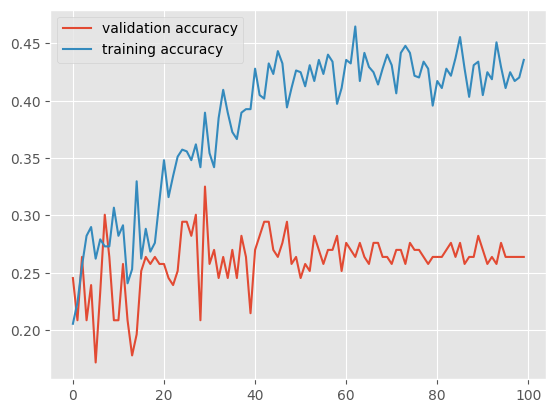

In [127]:
plt.style.use('ggplot')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.plot(running_corrects_history, label='training accuracy')
plt.legend()

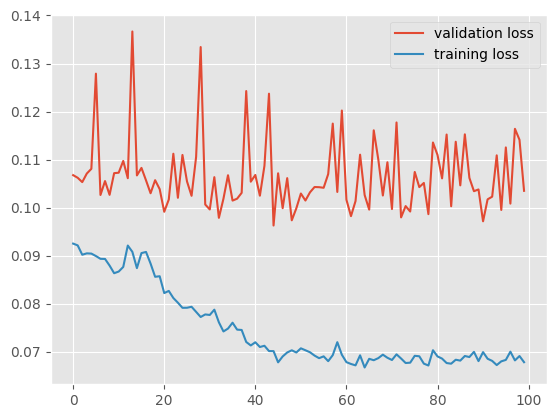

In [128]:
plt.style.use('ggplot')
plt.plot(val_running_loss_history, label='validation loss')
plt.plot(running_loss_history, label='training loss')

plt.legend()